[Индексы](http://krsdstat.gks.ru/wps/wcm/connect/rosstat_ts/krsdstat/resources/243853004fa8bd75a5a0a7f73a3a624e/2002-2019_04.htm) потребительских цен на товары и услуги по Краснодарскому краю за 2002-2019гг.

[Здесь](http://www.gks.ru/dbscripts/cbsd/DBInet.cgi?pl=1921001) можно запросить средние потребительские цены (тарифы) на товары и услуги по Краснодарскому краю на 2003-2018гг.

# Подготовка и импорт и обзор данных данных

In [ ]:
%%capture
!pip uninstall scipy -y
!pip install scipy==1.2
!pip install statsmodels
!pip install pmdarima
##!pip install pyts

%matplotlib inline

import numpy as np
import pandas as pd
import pmdarima as pm
import matplotlib.pyplot as plt
from fbprophet import Prophet
from pmdarima.arima.utils import ndiffs
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.iolib.table import SimpleTable
from statsmodels.stats.weightstats import DescrStatsW
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.stattools import jarque_bera
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, month_plot, quarter_plot, seasonal_plot

def metrics(forecast, actual, mname):
    #forecast = fc_series.values
    try:
        mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  
        me = np.mean(forecast - actual)             
        mae = np.mean(np.abs(forecast - actual))    
        mpe = np.mean((forecast - actual)/actual)   
        rmse = np.mean((forecast - actual)**2)**.5  
        corr = np.corrcoef(forecast, actual)[0,1]  
        mins = np.amin(np.hstack([forecast[:,None], actual[:,None]]), axis=1)
        maxs = np.amax(np.hstack([forecast[:,None], actual[:,None]]), axis=1)
        minmax = 1 - np.mean(mins/maxs)    
        mm = {'mape':mape, 'me':me, 'mae': mae, 
        'mpe': mpe, 'rmse':rmse,
        'corr':corr, 'minmax':minmax}
        return mm
    except:
        pass

#грузим из файла таблицу с индексами цен и выводим
df = pd.read_csv('kr_ind.csv', sep=';', encoding='utf8')
dff_prev = df

In [ ]:
df

,Month,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
0,January,103.7,101.19,101.6,103.00,102.7,101.90,101.60,101.46,101.28,102.24,100.54,101.20,100.72,104.25,100.90,100.42,100.50
1,February,100.2,101.01,100.5,101.30,101.3,101.00,101.10,102.45,100.65,100.95,100.76,100.45,100.81,101.92,100.61,100.11,99.99
2,March,100.5,100.68,100.5,101.90,100.6,100.40,101.70,101.45,100.91,100.45,100.52,100.18,100.88,101.09,100.50,100.19,100.05
3,April,101.6,101.20,101.2,101.80,99.8,100.60,101.70,101.00,100.43,100.56,100.12,100.60,101.20,100.88,100.67,100.50,100.41
4,May,103.0,101.07,101.1,101.30,100.9,100.80,101.70,100.94,100.43,100.90,100.76,101.12,101.30,100.28,100.52,100.93,100.42
5,June,100.4,101.96,101.2,100.90,100.4,101.60,101.10,100.66,100.43,100.31,100.81,100.43,100.74,99.90,100.38,100.56,100.43
6,July,97.9,100.38,100.6,99.20,99.5,100.30,100.01,100.28,100.07,100.29,101.20,100.43,100.50,100.60,100.42,99.75,100.13
7,August,102.0,99.78,100.4,99.95,100.3,99.97,100.70,100.30,100.62,100.28,100.16,100.44,100.54,100.27,100.09,99.47,100.32
8,September,100.5,100.76,100.8,100.80,101.1,100.70,101.20,100.06,101.82,100.10,100.63,100.29,101.06,100.53,100.23,99.79,100.29
9,October,100.8,100.34,101.5,100.30,100.8,101.80,100.90,100.13,100.16,100.14,100.18,100.55,100.63,101.15,100.48,100.21,100.16


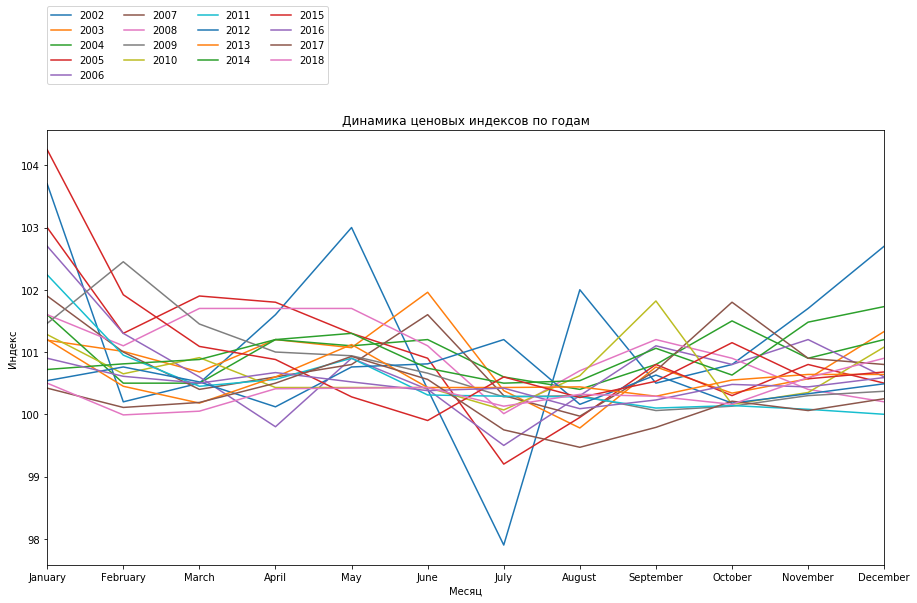

In [ ]:
ax = df.plot(figsize=(15, 8), title='Динамика ценовых индексов по годам', fontsize=10)
ax.set(xlabel='Месяц')
ax.set(ylabel='Индекс')
ax.set_xticks(range(0, 12))
ax.set_xticklabels(df['Month'].values)
plt.legend(bbox_to_anchor=(0,1.105),loc="lower left", borderaxespad=0., ncol=4)
plt.show()

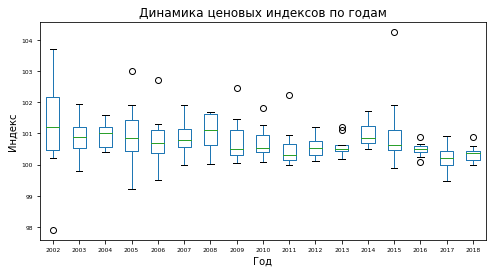

In [ ]:
ax = df.plot(figsize=(8, 4), title='Динамика ценовых индексов по годам', kind='box', fontsize=6)
ax.set(xlabel='Год')
ax.set(ylabel='Индекс')
plt.show()

In [ ]:
#'выпряемляем' таблицу в плоский временной ряд
prices = df.drop('Month', axis=1).values.flatten('F').astype(np.float).flatten()

print('Среднее:', np.mean(prices), 'Max:', np.max(prices), 'Min:', np.min(prices))
print('Стд откл:', np.std(prices))

print('Средние и стд откл по годам:')
pd.DataFrame(np.column_stack(
    (np.array(df.columns[1:]), df.mean(axis=0).values, df.std(axis=0).values)), 
    columns=['year', 'mean', 'std'])

Среднее: 100.75573529411766 Max: 104.25 Min: 97.9
Стд откл: 0.7221956910736214
Средние и стд откл по годам:


,year,mean,std
0,2002,101.25,1.55007
1,2003,100.856,0.565323
2,2004,100.958,0.403301
3,2005,100.979,0.990743
4,2006,100.767,0.813894
5,2007,100.897,0.59809
6,2008,101.026,0.600158
7,2009,100.783,0.714033
8,2010,100.686,0.505919
9,2011,100.525,0.620359


descriptive statistics
       var                mean               std               std_mean     
----------------------------------------------------------------------------
0.5215666162053054 100.75573529411766 0.7221956910736212 0.05068820055879084
----------------------------------------------------------------------------
jarque_bera test
       JB               p-value             skewness           kurtosis     
----------------------------------------------------------------------------
232.903794266549 2.664303331633017e-51 1.1687503753650614 7.6836456553240655
----------------------------------------------------------------------------
adfuller test
        JB              p-value       usedlag
---------------------------------------------
-2.61245800781669 0.09044968974977885    13  
---------------------------------------------
ndiffs test (сколько раз надо проинетегрировать ряд по разным критериям)
ADF KPSS PP
-----------
 0   1   0 
-----------


/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning:

invalid value encountered in sqrt



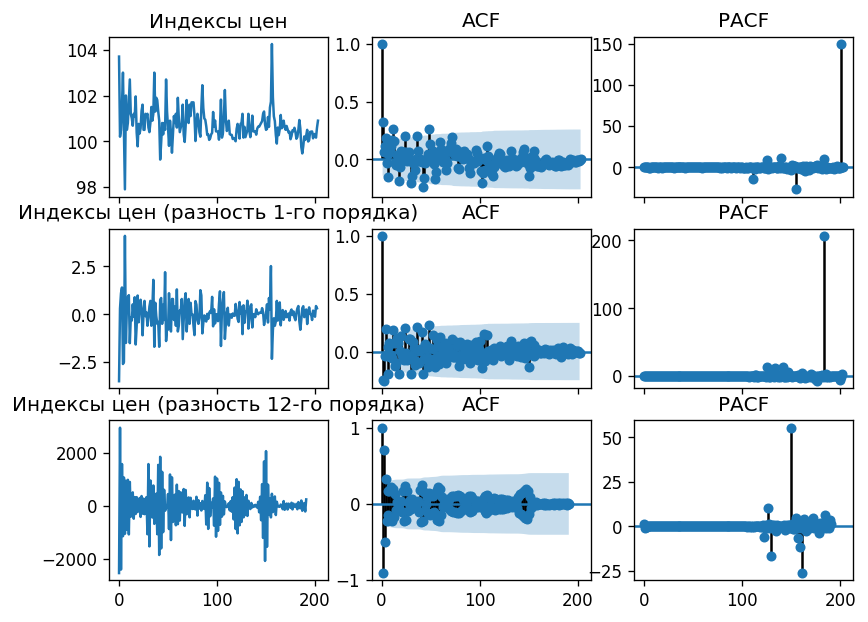

In [ ]:
#проверим разные статистические характеристики
result = DescrStatsW(prices)
v = [[result.var, result.mean, result.std, result.std_mean]]
h = [u'var', u'mean', u'std', u'std_mean']
print('descriptive statistics'); print(SimpleTable(v, h))

#проверим ряд на нормальность (тест Харки-Бера)
result = jarque_bera(prices)
h = [u'JB', u'p-value', u'skewness', u'kurtosis']
print('jarque_bera test'); print(SimpleTable([result], h))

#проверяем ряд на стационарность расширенным тестом Дики-Фуллера (ADF) 
result = adfuller(prices)
h = [u'JB', u'p-value', u'usedlag']
print('adfuller test'); print(SimpleTable([result[:3]], h))

#проверяем сколько раз надо проинтегрировать ряд чтобы он стал стационарным (если он не стационарный)
v = [[ndiffs(prices, test='adf'), ndiffs(prices, test='kpss'), ndiffs(prices, test='pp')]]
h = [u'ADF', u'KPSS', u'PP']
print('ndiffs test (сколько раз надо проинетегрировать ряд по разным критериям)'); print(SimpleTable( v, h))

plt.rcParams.update({'figure.figsize':(8, 6), 'figure.dpi':120})
fig, axes = plt.subplots(3, 3, sharex=True)

#выводим график исходного ряда, автокорреляцию (ACF) и частичную автокорреляцию (PACF)
axes[0, 0].plot(prices); axes[0, 0].set_title('Индексы цен')
plot_acf(prices, ax=axes[0, 1]); axes[0, 1].set_title('ACF')
plot_pacf(prices, ax=axes[0, 2]); axes[0, 2].set_title('PACF')

#выводим график проинтегрированного 1 раз ряда, автокорреляцию (ACF) и частичную автокорреляцию (PACF)
axes[1, 0].plot(np.diff(prices)); axes[1, 0].set_title('Индексы цен (разность 1-го порядка)')
plot_acf(np.diff(prices), ax=axes[1, 1]); axes[1, 1].set_title('ACF')
plot_pacf(np.diff(prices), ax=axes[1, 2]); axes[1, 2].set_title('PACF')

#выводим график проигтегрированного 12 раз ряда, автокорреляцию (ACF) и частичную автокорреляцию (PACF)
axes[2, 0].plot(np.diff(prices, n=12)); axes[2, 0].set_title('Индексы цен (разность 12-го порядка)')
plot_acf(np.diff(prices, n=12), ax=axes[2, 1]); axes[2, 1].set_title('ACF')
plot_pacf(np.diff(prices, n=12), ax=axes[2, 2]); axes[2, 2].set_title('PACF')

plt.show()

# ARIMA

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                  204
Model:             SARIMAX(0, 1, 2)x(1, 0, 1, 12)   Log Likelihood                -190.089
Date:                            Tue, 04 Jun 2019   AIC                            392.178
Time:                                    09:32:17   BIC                            412.057
Sample:                                         0   HQIC                           400.220
                                            - 204                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0002      0.000     -1.255      0.210      -0.001       0.000
ma.L1         -0.6850      0.056   

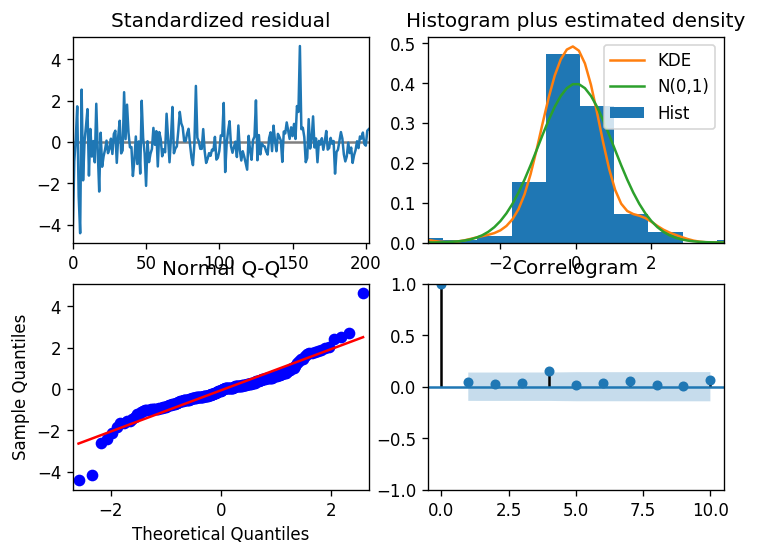

In [ ]:
#подбираем параметры ARIMA
model = pm.auto_arima(prices, start_p=1, start_q=1,
                      test='kpss',       
                      seasonal_test='ocsb',
                      max_p=5, max_q=5, 
                      m=12,             # frequency of series
                      d=None,           
                      seasonal=True,    
                      start_P=0, 
                      D=None,
                      trace=False,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

#смотрим, что получилось
print(model.summary())
#'диагностические' графики
model.plot_diagnostics(figsize=(7,5))
plt.show()

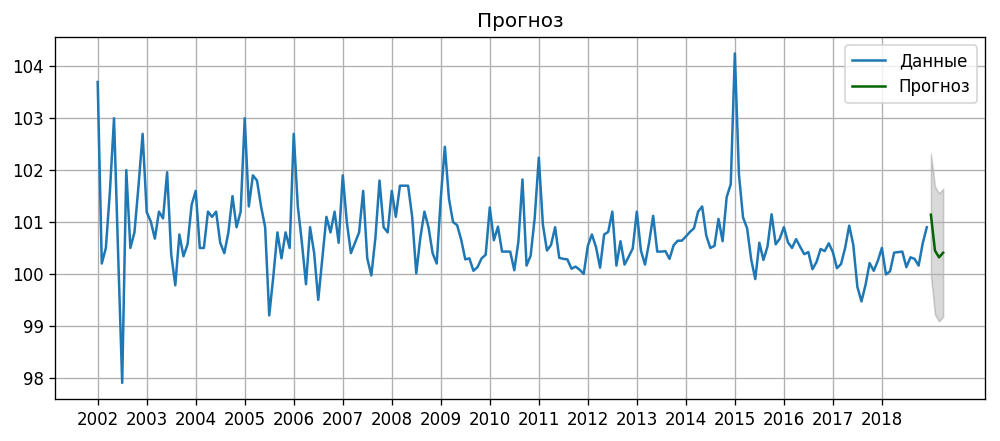

In [ ]:
#делаем прогноз
n_periods = 4
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(prices), len(prices) + n_periods)

arima_fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

#прогноз и доверительные интервалы
plt.figure(figsize=(10, 4))
plt.plot(prices, label='Данные')
plt.plot(arima_fc_series, color='darkgreen', label='Прогноз')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
plt.xticks(np.arange(0, len(prices), 12), df.columns[1:].values)
plt.title("Прогноз")
plt.legend()
plt.grid()
plt.show()

In [ ]:
#выводим наш прогноз
print('Прогноз на 2019 год по модели ARIMA')
pd.DataFrame(np.column_stack((dff_prev['Month'].values[:n_periods], arima_fc_series.values)), columns=['month', 'index'])

Прогноз на 2019 год по модели ARIMA


,month,index
0,January,101.141
1,February,100.449
2,March,100.319
3,April,100.408


# Facebook Prophet

In [ ]:
ds = pd.date_range(start='2002-01-01', end='2019-01-01', freq='M').values
dff_prev, df = df, pd.DataFrame({'ds':ds, 'y':prices})

fbmodel = Prophet(interval_width=0.95, weekly_seasonality=True, daily_seasonality=True)
fbmodel.fit(df)

future = fbmodel.make_future_dataframe(periods=n_periods)
forecast = fbmodel.predict(future)
print('Прогноз')
fb_forecast = [100.003495, 99.464124, 99.184681, 98.824539]
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

Прогноз


,ds,yhat,yhat_lower,yhat_upper
203,2018-12-31,100.234924,99.218438,101.353386
204,2019-01-01,100.003495,98.957064,101.074115
205,2019-01-02,99.464124,98.347642,100.627064
206,2019-01-03,99.184681,98.155990,100.204668
207,2019-01-04,98.824539,97.724045,99.929885


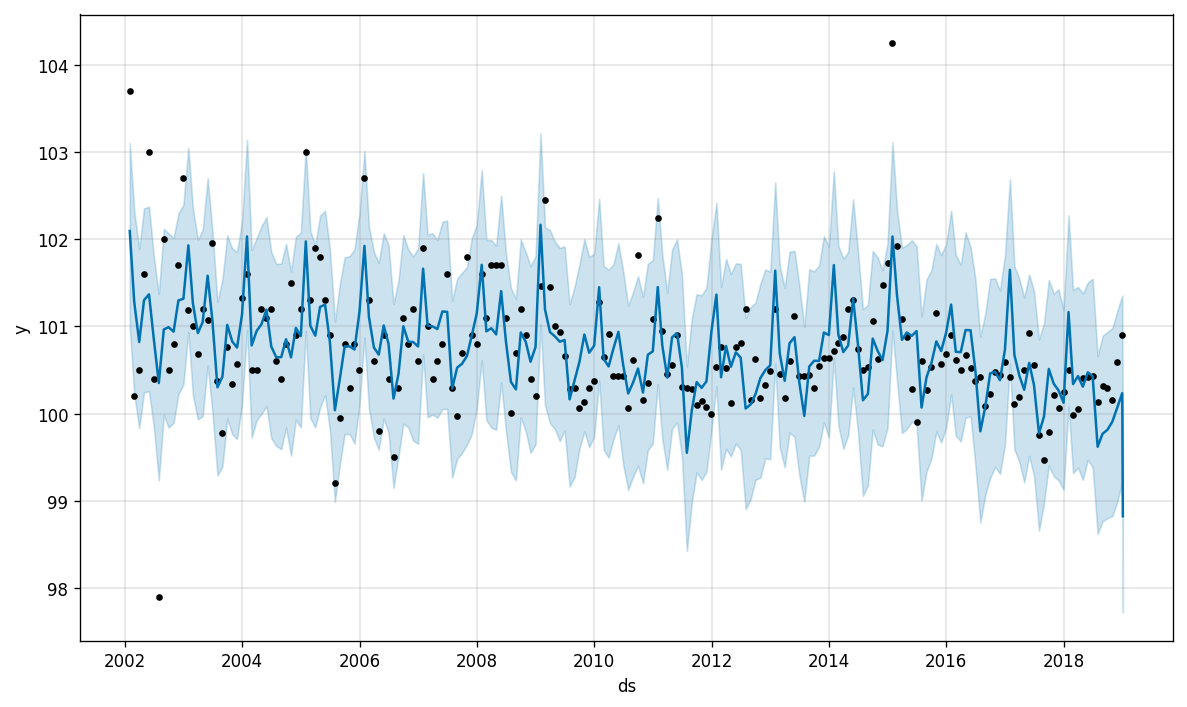

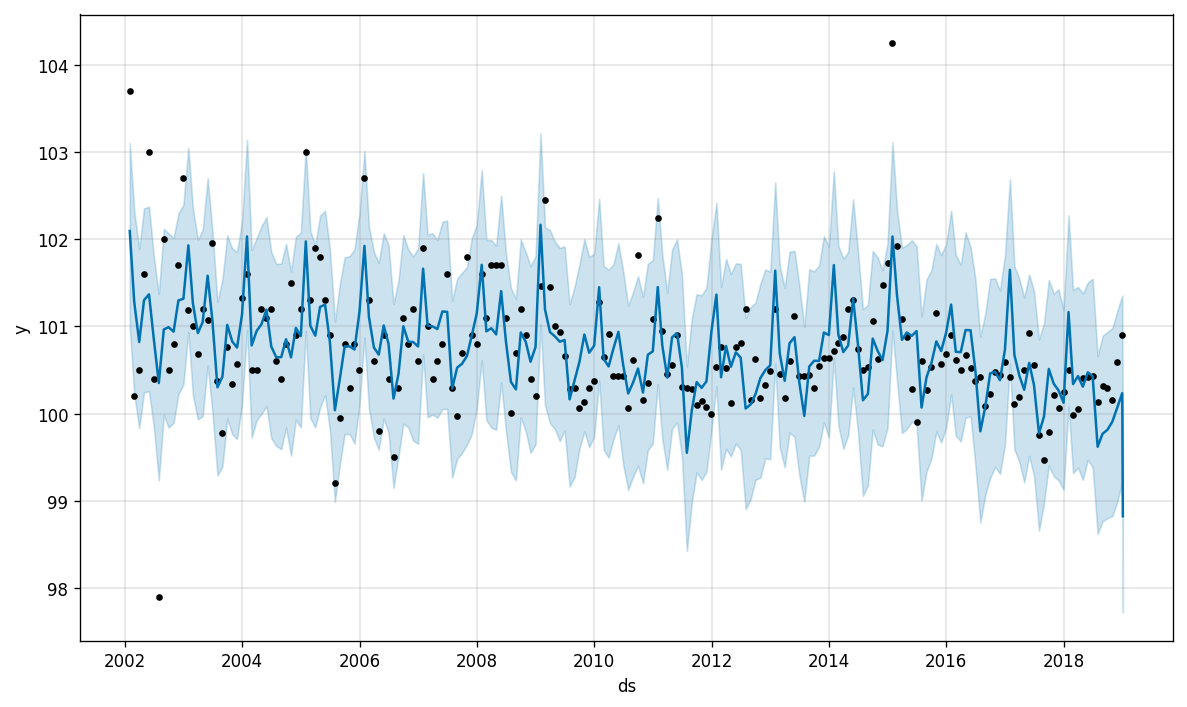

In [ ]:
fbmodel.plot(forecast)

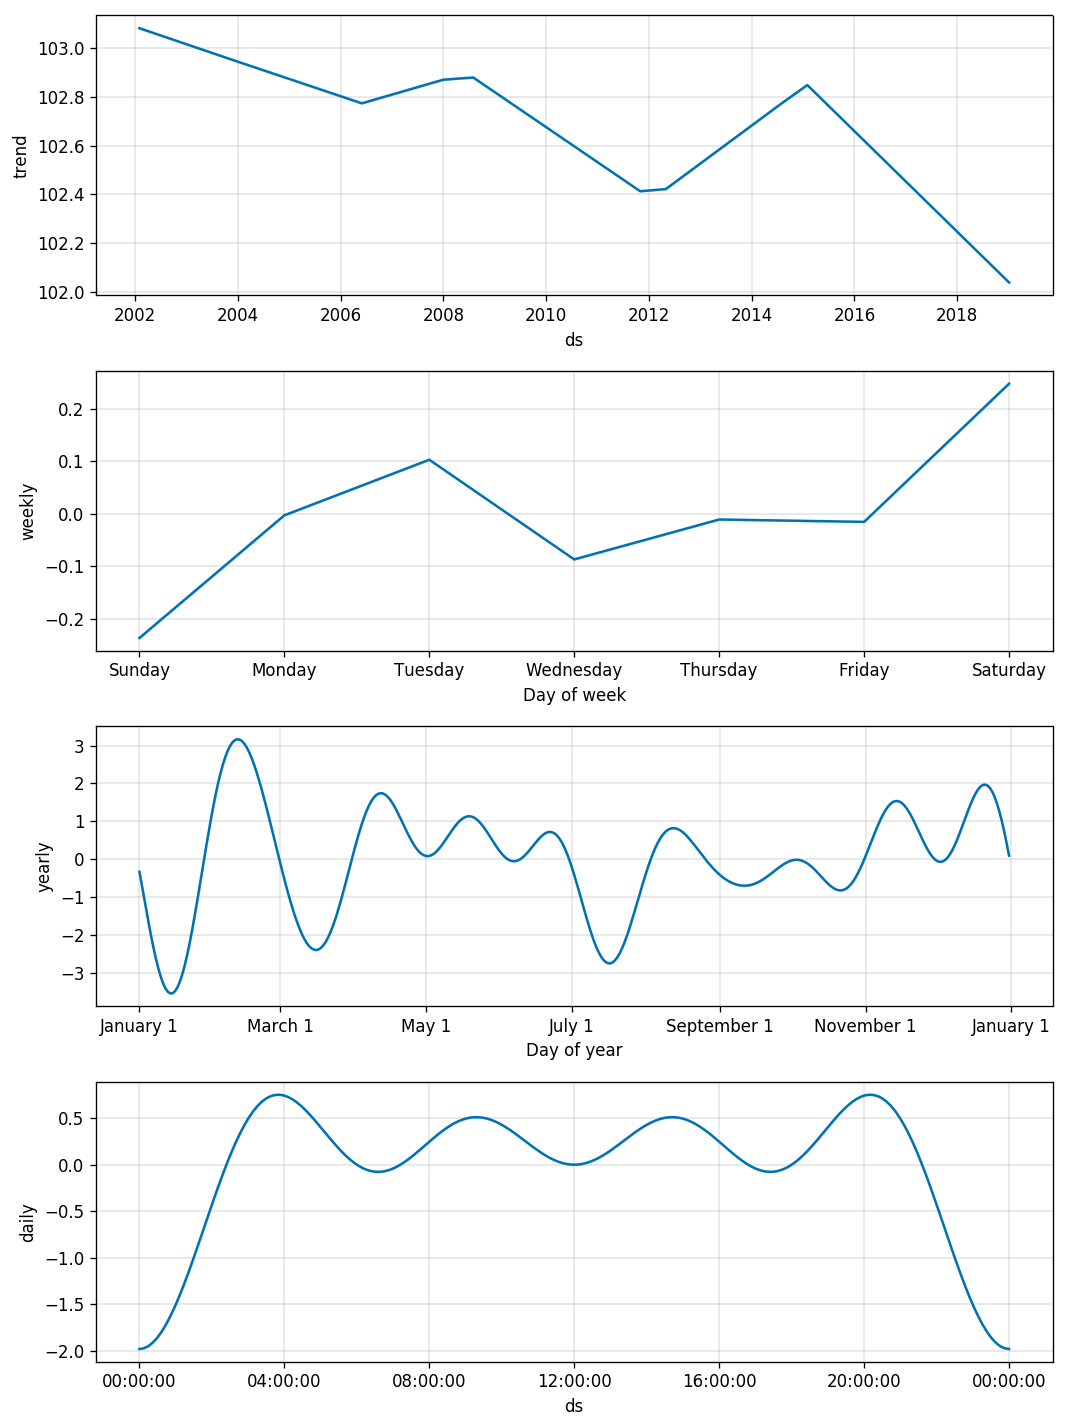

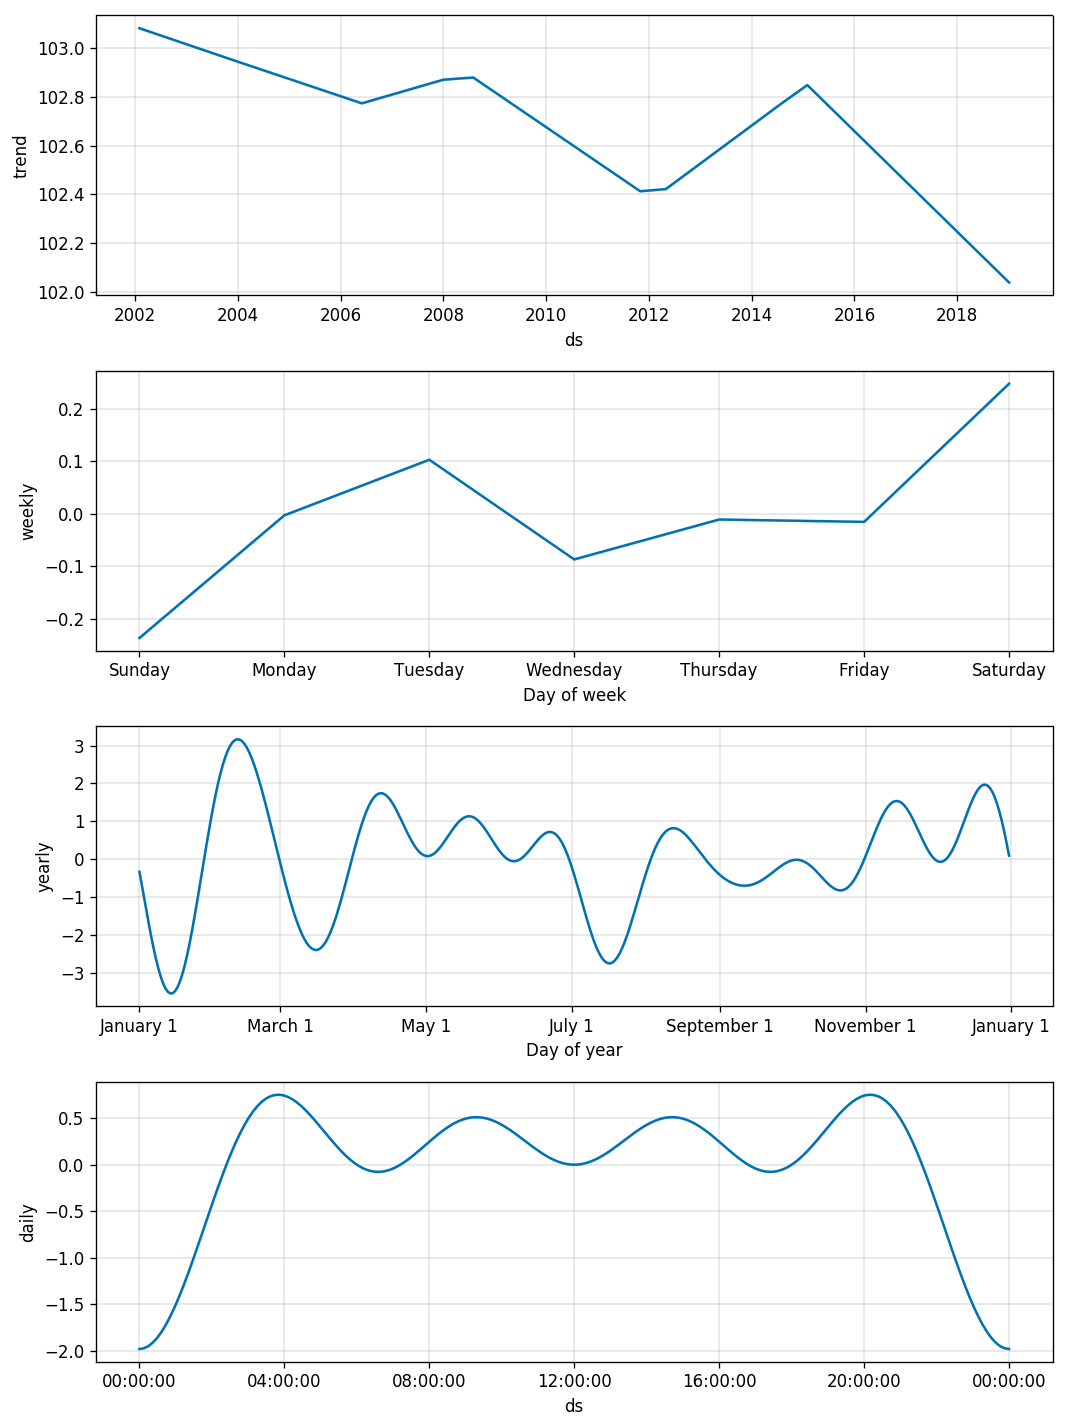

In [ ]:
fbmodel.plot_components(forecast)

# Скользящие средние (сглаживание)

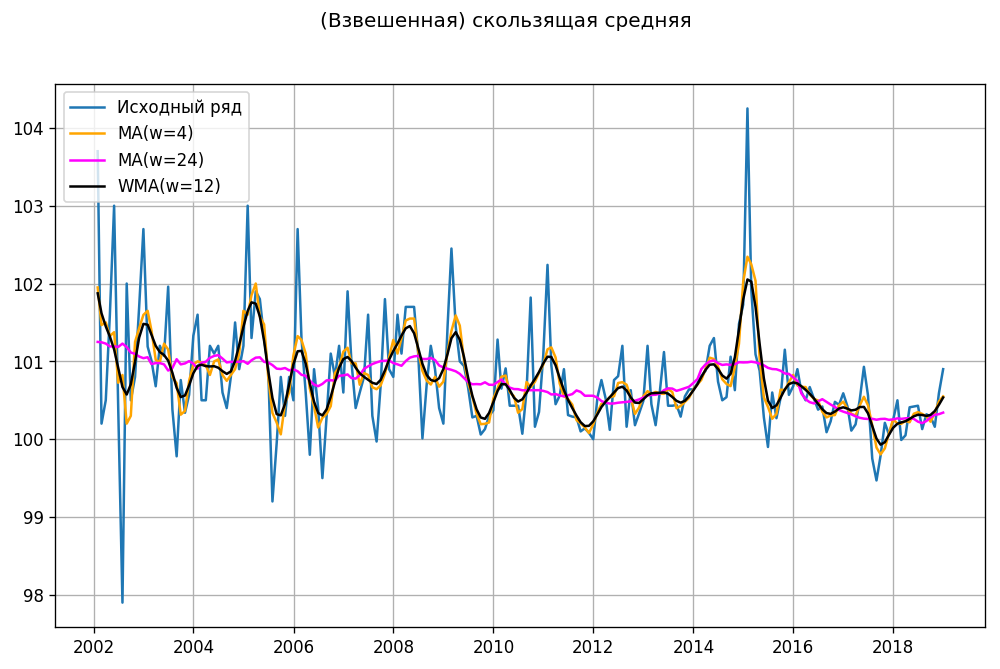

In [ ]:
plt.rcParams.update({'figure.figsize':(10, 6), 'figure.dpi':120})
#здесь простая скользящая средняя (moving average) и взвешенная с разным окном
rolling_mean4 = df.y.rolling(window=4, center=True, min_periods=1).mean()
rolling_mean12 = df.y.rolling(window=24, center=True, min_periods=1).mean()
rolling_wmean12 = df.y.rolling(window=12, win_type='bohman', center=True, min_periods=1).mean()
plt.plot(df.ds, df.y, label='Исходный ряд')
plt.plot(df.ds, rolling_mean4, label='MA(w=4)', color='orange')
plt.plot(df.ds, rolling_mean12, label='MA(w=24)', color='magenta')
plt.plot(df.ds, rolling_wmean12, label='WMA(w=12)', color='black')
plt.suptitle('(Взвешенная) скользящая средняя')
plt.legend(loc='upper left')
plt.grid()
plt.show()

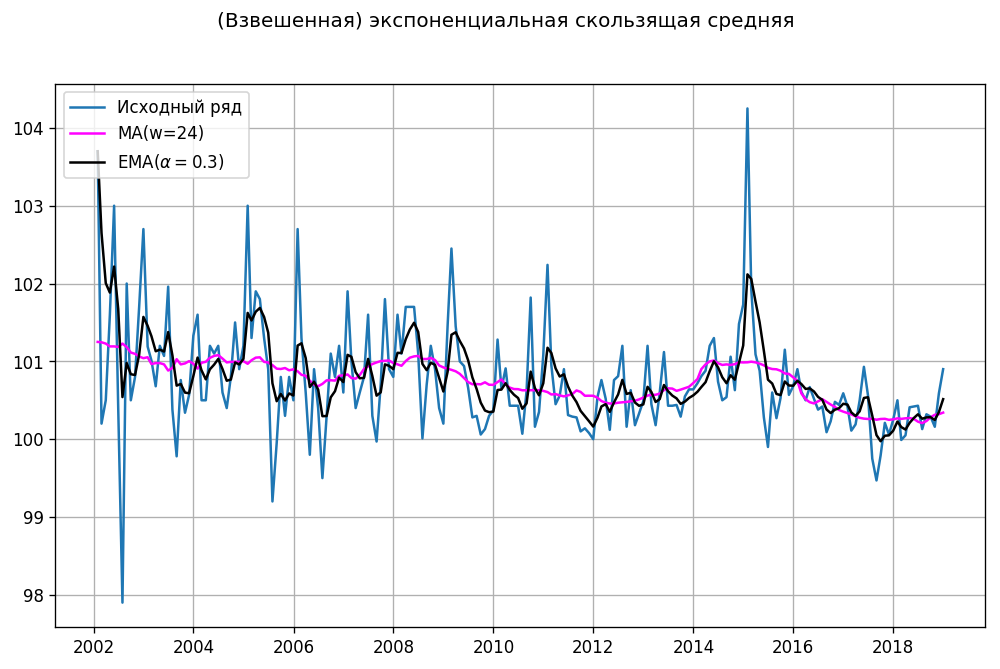

In [ ]:
#Экспоненциальная скользащая средняя
exp01 = df.y.ewm(alpha=0.1, adjust=False).mean()
exp03 = df.y.ewm(alpha=0.3, adjust=False).mean()
rolling_mean12 = df.y.rolling(window=24, center=True, min_periods=1).mean()
plt.plot(df.ds, df.y, label='Исходный ряд')
plt.plot(df.ds, rolling_mean12, label='MA(w=24)', color='magenta')
#plt.plot(df.ds, exp01, label=r'EMA($\alpha=0.1$)', color='orange')
plt.plot(df.ds, exp03, label=r'EMA($\alpha=0.3$)', color='black')
plt.suptitle('(Взвешенная) экспоненциальная скользящая средняя')
plt.legend(loc='upper left')
plt.grid()
plt.show()

In [ ]:
dff = pd.DataFrame({'ds':ds,
                    'MA(w=4)':rolling_mean4.values,
                    'MA(w=12)':rolling_mean12.values,
                    'WMA(w=12)':rolling_wmean12.values,
                    'EMA(01)':exp01.values, 
                    'EMA(03)':exp03.values})
print('Прогноз по простым моделям')
dff.tail()

Прогноз по простым моделям


,ds,MA(w=4),MA(w=12),WMA(w=12),EMA(01),EMA(03)
199,2018-08-31,100.2925,100.233529,100.299095,100.275439,100.280094
200,2018-09-30,100.2250,100.281250,100.312199,100.276895,100.283066
201,2018-10-31,100.3400,100.314000,100.362104,100.265206,100.246146
202,2018-11-30,100.4850,100.321429,100.441770,100.297685,100.349302
203,2018-12-31,100.5500,100.341538,100.535461,100.357917,100.514511


# AR (простая авторегрессия) и Холта-Винтера (экспоненциальное сглаживание)

Параметры модели AR:  [ 3.58799071e+01  4.49124498e-01 -2.73314281e-02  1.51314075e-02
  1.26560791e-01 -5.75435857e-02 -1.01602697e-01  3.70793891e-02
  4.57516871e-02 -1.68867790e-02  1.14851993e-01 -3.85357628e-02
  2.10049926e-01  1.20250880e-02 -1.24965822e-01]
Параметры модели HW:  {'smoothing_level': 0.12884539460844655, 'smoothing_slope': 3.429364772452467e-18, 'smoothing_seasonal': 2.203876392144025e-14, 'damping_slope': nan, 'initial_level': 101.64207071633268, 'initial_slope': 0.0, 'initial_seasons': array([ 0.46832303, -0.35744025, -0.50731482, -0.39915112, -0.20694052,
       -0.51312712, -1.13666333, -0.8952732 , -0.59383093, -0.61552037,
       -0.54812482, -0.38227058]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


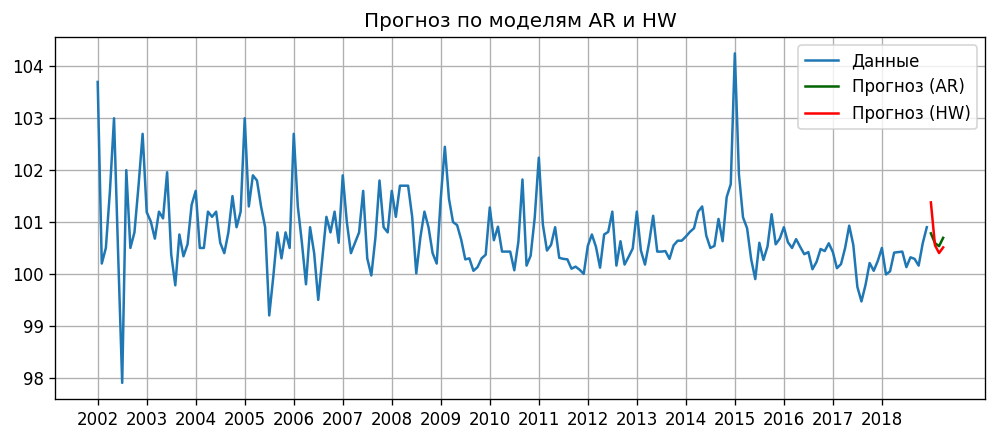

In [ ]:
#подбираем параметры модели AR
ar_model = AR(prices)
ar_model_fit = ar_model.fit(maxiter=1000)

#подбираем параметры модели Holt-Winter
hw_model = ExponentialSmoothing(prices, trend='add', seasonal='add', seasonal_periods=12)
hw_model_fit = hw_model.fit()

print('Параметры модели AR: ', ar_model_fit.params)
print('Параметры модели HW: ', hw_model_fit.params)
#print(ar_model_fit.aic, ar_model_fit.pvalues)

#делаем прогноз
ar_fc_series = ar_model_fit.predict(len(prices), len(prices) + n_periods - 1)
hw_fc_series = hw_model_fit.predict(len(prices), len(prices) + n_periods - 1)

#строим график
index_of_fc = np.arange(len(prices), len(prices) + n_periods)
ar_fc_series = pd.Series(ar_fc_series, index=index_of_fc)
hw_fc_series = pd.Series(hw_fc_series, index=index_of_fc)

plt.figure(figsize=(10, 4))
plt.plot(prices, label='Данные')
plt.plot(ar_fc_series, color='darkgreen', label='Прогноз (AR)')
plt.plot(hw_fc_series, color='red', label='Прогноз (HW)')
plt.xticks(np.arange(0, len(prices), 12), dff_prev.columns[1:].values)
plt.title("Прогноз по моделям AR и HW")
plt.legend()
plt.grid()
plt.show()

In [ ]:
#выводим наш прогноз
print('Прогноз на 2019 год по модели AR и HW')
pd.DataFrame(
    np.column_stack((dff_prev['Month'].values[:n_periods], ar_fc_series.values, hw_fc_series.values)), 
    columns=['month', 'AR', 'HW'])

Прогноз на 2019 год по модели AR и HW


,month,AR,HW
0,January,100.781,101.378
1,February,100.592,100.552
2,March,100.536,100.402
3,April,100.695,100.511


# Сравнение моделей
метрики и прогнозы по всем моделям

In [ ]:
actual = np.array([101.01, 100.40, 100.30, 100.40])
#выводим метрики по всем моделям
ar_m = metrics(ar_fc_series.values, actual, 'AR')
hw_m = metrics(hw_fc_series.values, actual, 'HW')
arima_m = metrics(arima_fc_series.values, actual, 'ARIMA')
fb_m = metrics(np.array(fb_forecast), actual, 'Facebook Prophet')

df_mectrics = list(map(lambda x: list(x.values()), [ar_m, hw_m, arima_m, fb_m]))

df_mectrics = pd.DataFrame(
    np.column_stack((['AR', 'HW', 'ARIMA', 'FB Prophet'],
                     np.round(df_mectrics, 6),
                    )),
    columns=['model', 'mape', 'me', 'mae', 'mpe', 'rmse', 'corr', 'minmax'])
    
print('Метрики по разным моделям')
df_mectrics

Метрики по разным моделям


,model,mape,me,mae,mpe,rmse,corr,minmax
0,AR,0.002368,0.123664,0.238033,0.001236,0.240878,0.855311,0.002364
1,HW,0.001821,0.183324,0.183324,0.001821,0.21293,0.999235,0.001816
2,ARIMA,0.000514,0.05176,0.05176,0.000514,0.070603,0.999003,0.000513
3,FB Prophet,0.011524,-1.15829,1.15829,-0.011524,1.184792,0.835704,0.011524


In [ ]:
print('Прогноз на 2019 год по разным моделям')
df_all = pd.DataFrame(
    np.column_stack((dff_prev['Month'].values[:n_periods], 
                     actual,
                     arima_fc_series,
                     ar_fc_series.values, 
                     hw_fc_series.values,
                     fb_forecast)), 
    columns=['Месяц', 'Реальные', 'ARIMA', 'AR', 'HW', 'FB Prophet'])
df_all

Прогноз на 2019 год по разным моделям


,Месяц,Реальные,ARIMA,AR,HW,FB Prophet
0,January,101.01,101.141,100.781,101.378,100.003
1,February,100.4,100.449,100.592,100.552,99.4641
2,March,100.3,100.319,100.536,100.402,99.1847
3,April,100.4,100.408,100.695,100.511,98.8245


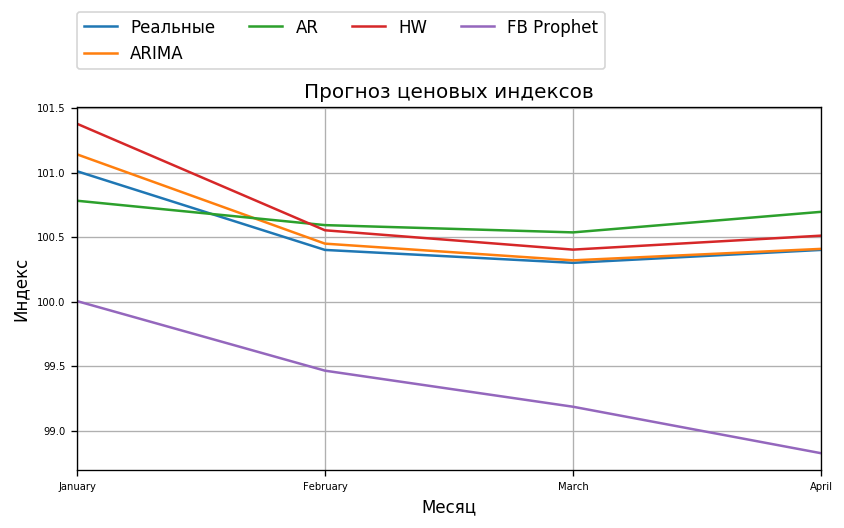

In [ ]:
#строим график
ax = df_all.plot(figsize=(8, 4), title='Прогноз ценовых индексов', fontsize=6)
ax.set(xlabel='Месяц')
ax.set(ylabel='Индекс')
ax.set_xticks(range(0, n_periods))
ax.set_xticklabels(dff_prev['Month'].values[0:n_periods])
plt.legend(bbox_to_anchor=(0,1.105),loc="lower left", borderaxespad=0., ncol=4)
plt.grid()
plt.show()